# Artificial Intelligence
# 464
# Project #7

## Variational Autoencoder (VAE) for Image Generation

In this project, you will implement a Variational Autoencoder (VAE), one of the fundamental algorithms in generative AI. VAEs are a type of generative model that learn to encode data into a latent space representation and then decode it back to generate new samples that resemble the original data distribution.
Unlike traditional autoencoders, VAEs enforce a specific structure on the latent space, making it suitable for generative tasks. By the end of this project, you will have built a VAE capable of generating new images similar to those in your training dataset.

## Part 1: Understanding VAEs (Theory)
A VAE consists of two main components:

Encoder: Maps input data to a probability distribution in latent space

Decoder: Maps points from the latent space back to the original data space

Unlike standard autoencoders, VAEs don't encode inputs to single points in the latent space but to probability distributions (typically Gaussian). This stochastic encoding enables:

00. Smooth latent space for better interpolation
01. The ability to sample new points from the latent space
02. Regularization through the KL divergence loss

### The VAE Loss Function

The VAE loss consists of two terms:

00. Reconstruction Loss: Measures how well the decoder can reconstruct the input from its latent representation
01. KL Divergence Loss: Encourages the encoded distributions to be close to a standard normal distribution

$
L(\theta, \phi) = -\mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] + D_{KL}\left( q_{\phi}(z|x) \,\|\, p(z) \right)
$

where:

00. $\theta$ and $\phi$ are the parameters of the decoder and encoder
01. $q_\phi(z|x)$ is the approximate posterior (encoder output)
02. $p_\theta(x|z)$ is the likelihood (decoder output)
03. $p(z)$ is the prior distribution (typically $\mathcal{N}(0, I)$)

### The Reparameterization Trick

To enable backpropagation through the sampling process, VAEs use the reparameterization trick:
Instead of directly sampling $z \sim \mathcal{N}(\mu, \sigma^2)$, we reparameterize as:
$z = \mu + \sigma \cdot \epsilon$, where $\epsilon \sim \mathcal{N}(0, 1)$
This allows gradients to flow through the network while maintaining the stochastic nature of the model.

## Part 2: Implementing the VAE (Code)

### Setup

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)

### Load and Preprocess Data

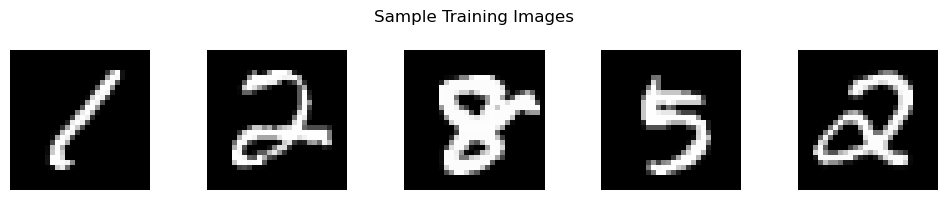

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display some sample images
def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for i, img in enumerate(images):
        axes[i].imshow(img.view(28, 28).detach().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, _ = next(dataiter)
show_images(images[:5], 'Sample Training Images')

### VAE Model Implementation

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
        self.latent_dim = latent_dim
    
    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x):
        # Flatten the input
        x = x.view(-1, 784)
        
        # Encode
        mu, logvar = self.encode(x)
        
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # Decode
        x_recon = self.decode(z)
        
        return x_recon, mu, logvar

# Instantiate the model
model = VAE()

### Loss Function

In [4]:
def loss_function(recon_x, x, mu, logvar):
    """
    VAE loss function combining reconstruction loss and KL divergence
    
    Parameters:
    recon_x: reconstructed input
    x: original input
    mu: mean of the encoder's latent space
    logvar: log variance of the encoder's latent space
    """
    # Binary Cross Entropy (reconstruction loss)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL Divergence
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

### Training Loop

In [5]:
def train(model, train_loader, optimizer, epoch):
    """Train the model for one epoch"""
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    print(f'Epoch: {epoch}, Average loss: {train_loss / len(train_loader.dataset):.4f}')
    return train_loss / len(train_loader.dataset)

### Evaluation Function

In [6]:
def test(model, test_loader):
    """Evaluate the model on test data"""
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    
    test_loss /= len(test_loader.dataset)
    print(f'Test set loss: {test_loss:.4f}')
    return test_loss

### Visualize Reconstructions

In [7]:
def visualize_reconstructions(model, data):
    """Visualize original and reconstructed images"""
    model.eval()
    with torch.no_grad():
        recon_batch, _, _ = model(data)
    
    # Plot original and reconstructed images
    n = min(5, data.size(0))
    comparison = torch.cat([data[:n], 
                           recon_batch.view(batch_size, 1, 28, 28)[:n]])
    
    fig, axes = plt.subplots(2, n, figsize=(12, 4))
    for i in range(n):
        # Original images
        axes[0, i].imshow(data[i].view(28, 28).numpy(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')
            
        # Reconstructed images
        axes[1, i].imshow(recon_batch[i].view(28, 28).numpy(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed')
            
    plt.tight_layout()
    plt.show()

### Generate New Images

In [8]:
def generate_images(model, num_images=10):
    """Generate new images by sampling from the latent space"""
    model.eval()
    with torch.no_grad():
        # Sample from the standard normal distribution
        z = torch.randn(num_images, model.latent_dim)
        
        # Decode the sampled points
        sample = model.decode(z)
        
    # Plot the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    for i in range(num_images):
        axes[i].imshow(sample[i].view(28, 28).numpy(), cmap='gray')
        axes[i].axis('off')
    plt.suptitle('Generated Images')
    plt.tight_layout()
    plt.show()

### Visualize Latent Space

In [9]:
def visualize_latent_space(model, test_loader, num_samples=1000):
    """Visualize the latent space by encoding test samples"""
    model.eval()
    z_list = []
    label_list = []
    
    with torch.no_grad():
        for i, (data, label) in enumerate(test_loader):
            # Encode data to get mu and logvar
            mu, logvar = model.encode(data.view(-1, 784))
            
            # Store the mean vectors and labels
            z_list.append(mu)
            label_list.append(label)
            
            if len(z_list) * data.size(0) >= num_samples:
                break
    
    # Concatenate all encoded vectors and labels
    z = torch.cat(z_list, dim=0)[:num_samples]
    labels = torch.cat(label_list, dim=0)[:num_samples]
    
    # Use t-SNE to reduce dimensionality to 2D if latent_dim > 2
    if model.latent_dim > 2:
        from sklearn.manifold import TSNE
        z_2d = TSNE(n_components=2).fit_transform(z.numpy())
    else:
        z_2d = z.numpy()
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab10', alpha=0.8)
    plt.colorbar(scatter, label='Digit')
    plt.title('Latent Space Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### Main Training Function

100%|████████████████████████████████████████| 469/469 [00:02<00:00, 160.94it/s]


Epoch: 1, Average loss: 165.9769
Test set loss: 128.3636


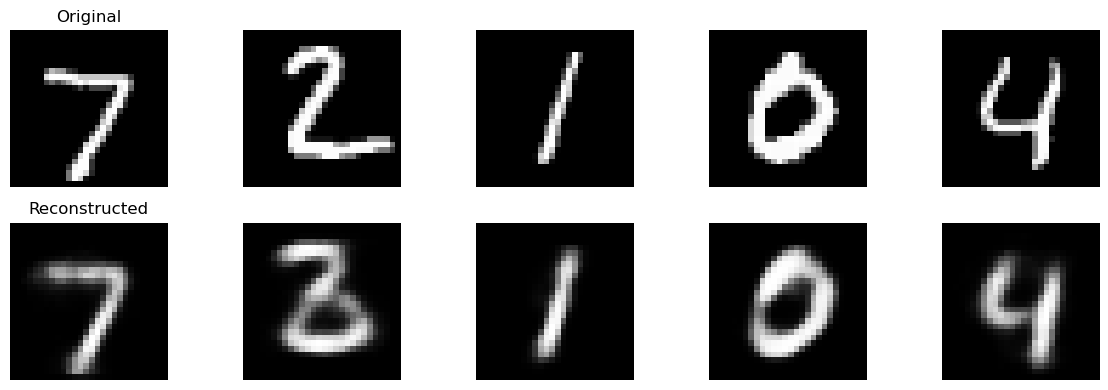

100%|████████████████████████████████████████| 469/469 [00:03<00:00, 152.06it/s]


Epoch: 2, Average loss: 122.2728
Test set loss: 116.2744


100%|████████████████████████████████████████| 469/469 [00:02<00:00, 162.97it/s]


Epoch: 3, Average loss: 115.1612
Test set loss: 112.0062


100%|████████████████████████████████████████| 469/469 [00:02<00:00, 163.45it/s]


Epoch: 4, Average loss: 112.0009
Test set loss: 109.9464


100%|████████████████████████████████████████| 469/469 [00:02<00:00, 164.69it/s]


Epoch: 5, Average loss: 110.1409
Test set loss: 108.8259


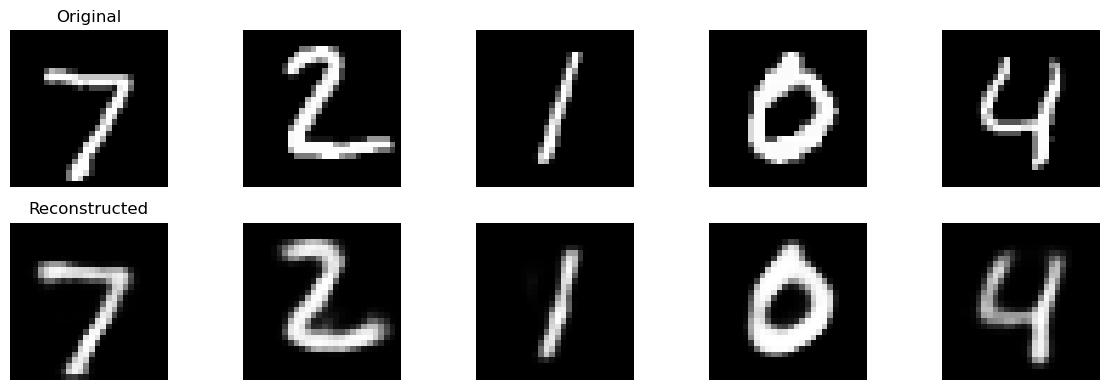

100%|████████████████████████████████████████| 469/469 [00:02<00:00, 164.97it/s]


Epoch: 6, Average loss: 108.8741
Test set loss: 107.6670


100%|████████████████████████████████████████| 469/469 [00:02<00:00, 166.25it/s]


Epoch: 7, Average loss: 108.0292
Test set loss: 106.9807


100%|████████████████████████████████████████| 469/469 [00:02<00:00, 159.38it/s]


Epoch: 8, Average loss: 107.3367
Test set loss: 106.6276


100%|████████████████████████████████████████| 469/469 [00:03<00:00, 143.60it/s]


Epoch: 9, Average loss: 106.8145
Test set loss: 106.3247


100%|████████████████████████████████████████| 469/469 [00:03<00:00, 149.24it/s]


Epoch: 10, Average loss: 106.3651
Test set loss: 105.6310


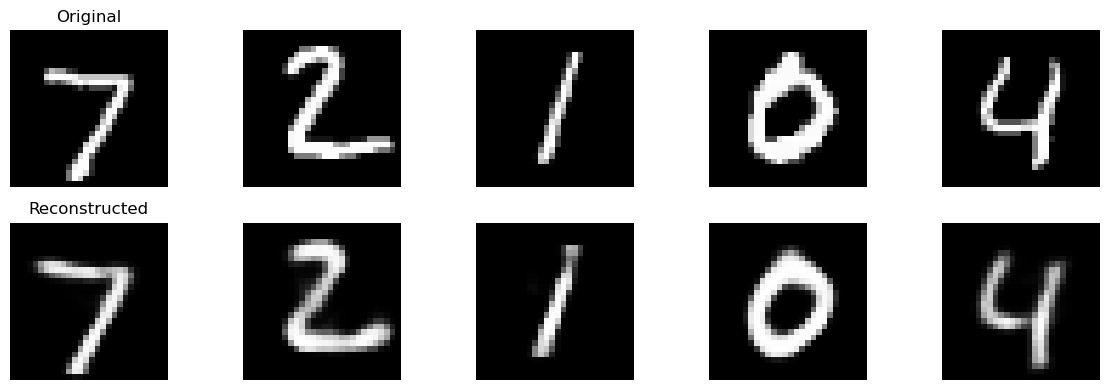

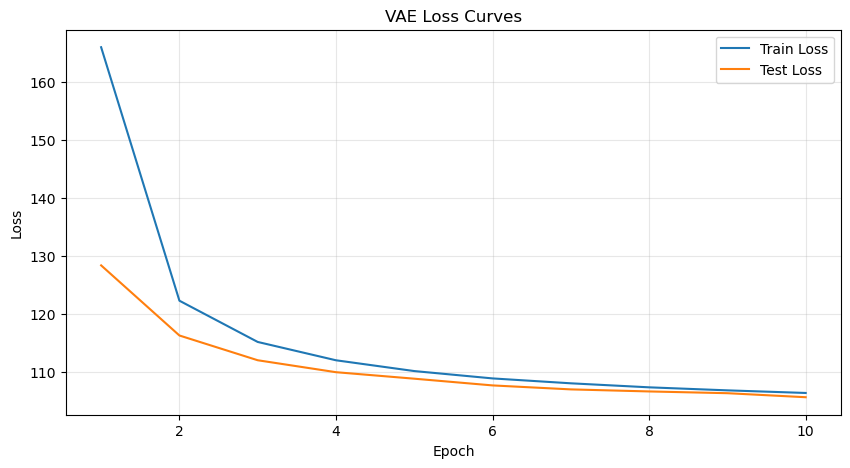

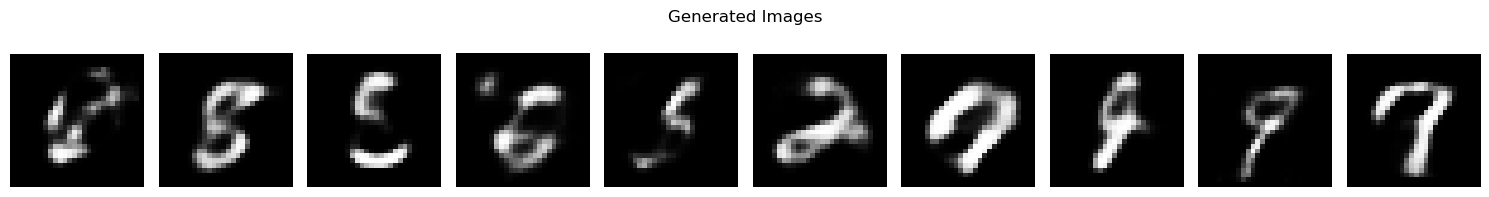

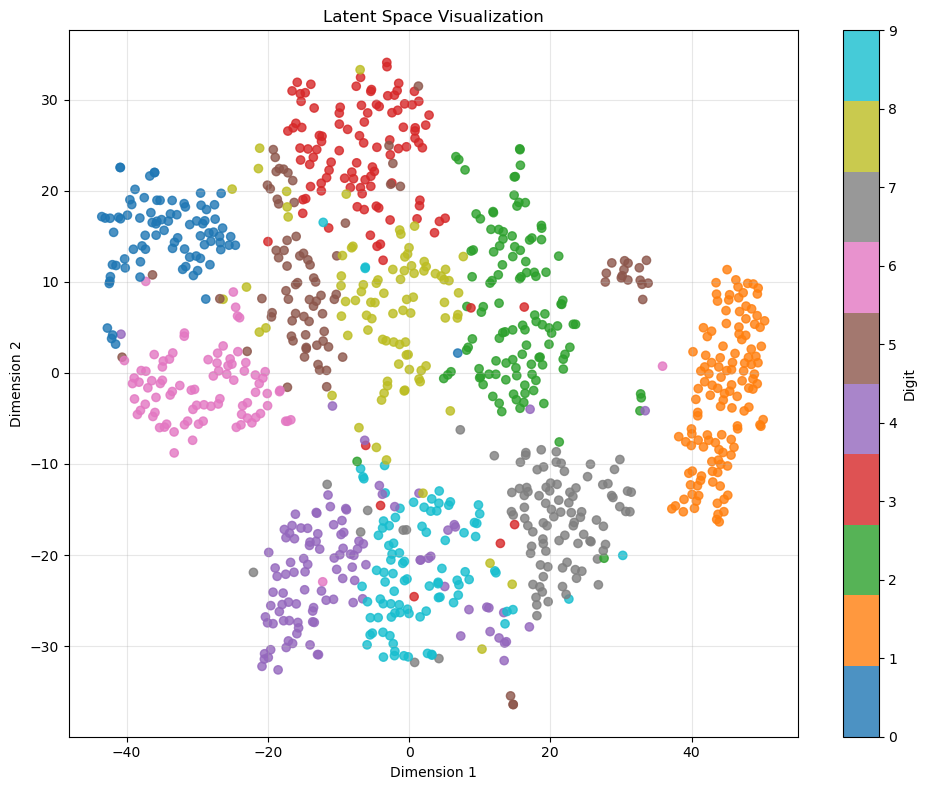

Model saved to 'vae_model.pth'


In [10]:
def main():
    # Hyperparameters
    learning_rate = 1e-3
    num_epochs = 10
    
    # Initialize model, optimizer
    model = VAE()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    train_losses = []
    test_losses = []
    
    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, optimizer, epoch)
        test_loss = test(model, test_loader)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        # Visualize reconstructions periodically
        if epoch % 5 == 0 or epoch == 1:
            data, _ = next(iter(test_loader))
            visualize_reconstructions(model, data)
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('VAE Loss Curves')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Generate new images
    generate_images(model)
    
    # Visualize latent space
    visualize_latent_space(model, test_loader)
    
    # Save the model
    torch.save(model.state_dict(), 'vae_model.pth')
    print("Model saved to 'vae_model.pth'")

if __name__ == "__main__":
    main()

## Part 3: Student Tasks

Complete the following exercises to deepen your understanding of VAEs:

### Exercise 1: Convolutional VAE (CVAE)

The current VAE implementation uses fully connected layers, which don't preserve spatial information. Modify the architecture to use convolutional layers for both the encoder and decoder.

In [11]:
#SOLUTION, skeleton provided as starter
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)
        
        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 128 * 7 * 7)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )
        
        self.latent_dim = latent_dim
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        h = F.relu(self.fc_decoder(z))
        h = h.view(-1, 128, 7, 7)
        h = self.decoder(h)
        return h
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [12]:
# Test the model
def test_conv_vae():
    model = ConvVAE()
    x = torch.randn(10, 1, 28, 28)  # Batch of 10 MNIST images
    x_recon, mu, logvar = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Reconstructed shape: {x_recon.shape}")
    print(f"Mu shape: {mu.shape}")
    print(f"Logvar shape: {logvar.shape}")
    
    # Generate some random images
    z = torch.randn(10, 20)  # 10 random latent vectors
    gen_images = model.decode(z)
    print(f"Generated images shape: {gen_images.shape}")
    
test_conv_vae()

Input shape: torch.Size([10, 1, 28, 28])
Reconstructed shape: torch.Size([10, 1, 28, 28])
Mu shape: torch.Size([10, 20])
Logvar shape: torch.Size([10, 20])
Generated images shape: torch.Size([10, 1, 28, 28])


### Exercise 2: Latent Space Exploration

Implement functions to explore the latent space through interpolation between two encoded images.

In [13]:
#SOLUTION, skeleton provided as starter
def interpolate_latent_space(model, img1, img2, steps=10):
    """
    Interpolate between two images in the latent space and generate the intermediate images
    
    Parameters:
    model: trained VAE model
    img1, img2: two input images to interpolate between
    steps: number of interpolation steps
    
    Returns:
    list: interpolated images
    """
    model.eval()
    
    # Reshape images if needed
    if len(img1.shape) == 2:
        img1 = img1.view(1, 1, 28, 28)
    if len(img2.shape) == 2:
        img2 = img2.view(1, 1, 28, 28)
    
    # Initialize storage for interpolated images
    interpolated_images = []
    
    with torch.no_grad():
        # Check if we're using a standard VAE or ConvVAE
        if isinstance(model, VAE):
            # For standard VAE
            mu1, logvar1 = model.encode(img1.view(-1, 784))
            mu2, logvar2 = model.encode(img2.view(-1, 784))
        else:
            # For ConvVAE
            mu1, logvar1 = model.encode(img1)
            mu2, logvar2 = model.encode(img2)
        
        # Create interpolation steps
        alphas = torch.linspace(0, 1, steps)
        
        # Generate interpolated latent vectors and decode them
        for alpha in alphas:
            # Interpolate in the latent space
            mu_interp = mu1 * (1 - alpha) + mu2 * alpha
            
            # Decode the interpolated latent vector
            decoded = model.decode(mu_interp)
            
            # Make sure decoded image has the right shape for visualization
            if len(decoded.shape) == 1:  # If output is flat (784,)
                decoded = decoded.view(28, 28)
            elif len(decoded.shape) == 2 and decoded.shape[0] == 1:  # If output is (1, 784)
                decoded = decoded.view(28, 28)
            elif len(decoded.shape) == 3:  # If output is (1, 28, 28)
                decoded = decoded.squeeze(0)
            elif len(decoded.shape) == 4:  # If output is (1, 1, 28, 28)
                decoded = decoded.squeeze(0).squeeze(0)
                
            interpolated_images.append(decoded.cpu())
        
        # Visualize the interpolation
        plt.figure(figsize=(15, 3))
        
        # Show original image 1
        plt.subplot(1, steps + 2, 1)
        if len(img1.shape) == 4:  # (batch, channel, height, width)
            plt.imshow(img1[0, 0].cpu(), cmap='gray')
        elif len(img1.shape) == 3:  # (channel, height, width)
            plt.imshow(img1[0].cpu(), cmap='gray')
        else:
            plt.imshow(img1.view(28, 28).cpu(), cmap='gray')
        plt.title('Original 1')
        plt.axis('off')
        
        # Show interpolated images
        for i in range(steps):
            plt.subplot(1, steps + 2, i + 2)
            plt.imshow(interpolated_images[i], cmap='gray')
            plt.title(f'α={alphas[i]:.2f}')
            plt.axis('off')
        
        # Show original image 2
        plt.subplot(1, steps + 2, steps + 2)
        if len(img2.shape) == 4:  # (batch, channel, height, width)
            plt.imshow(img2[0, 0].cpu(), cmap='gray')
        elif len(img2.shape) == 3:  # (channel, height, width)
            plt.imshow(img2[0].cpu(), cmap='gray')
        else:
            plt.imshow(img2.view(28, 28).cpu(), cmap='gray')
        plt.title('Original 2')
        plt.axis('off')
        
        plt.tight_layout()
        plt.suptitle('Latent Space Interpolation')
        plt.show()
    
    # Return the list of interpolated images
    return interpolated_images

Testing ConvVAE:
Input shape: torch.Size([10, 1, 28, 28])
Reconstructed shape: torch.Size([10, 1, 28, 28])
Mu shape: torch.Size([10, 20])
Logvar shape: torch.Size([10, 20])
Generated images shape: torch.Size([10, 1, 28, 28])

Testing Latent Space Interpolation:
Testing latent space interpolation...
Image 1 shape: torch.Size([1, 1, 28, 28])
Image 2 shape: torch.Size([1, 1, 28, 28])


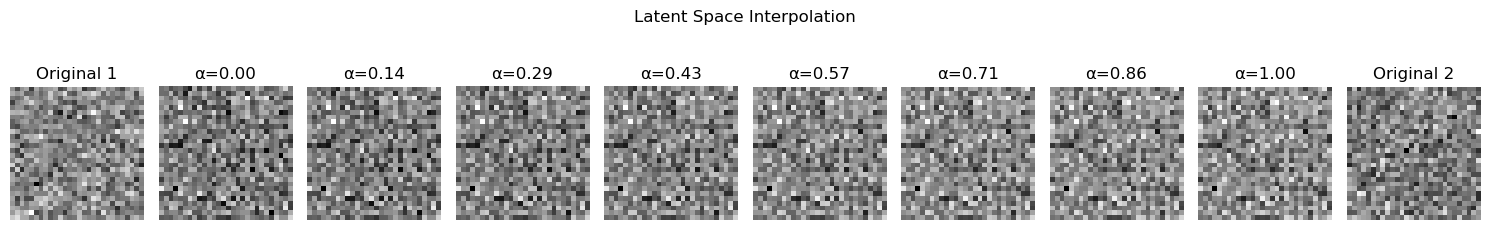

Interpolation successful!
Number of interpolated images: 8
Shape of interpolated images: torch.Size([28, 28])


In [14]:
# Test the interpolate_latent_space function
def test_interpolation():
    # Load or create a trained model
    model = VAE()  # You can use the basic VAE model for testing
    
    # Set to evaluation mode
    model.eval()
    
    # Create two test images (can be random or from dataset)
    # For testing with random images:
    img1 = torch.randn(1, 1, 28, 28)
    img2 = torch.randn(1, 1, 28, 28)
    
    print("Testing latent space interpolation...")
    print("Image 1 shape:", img1.shape)
    print("Image 2 shape:", img2.shape)
    
    try:
        # Test the interpolation function
        result = interpolate_latent_space(model, img1, img2, steps=8)
        
        # Check if we got a result
        if result is None:
            print("Warning: interpolate_latent_space returned None. Check the implementation.")
            return None
        
        print("Interpolation successful!")
        print(f"Number of interpolated images: {len(result)}")
        print(f"Shape of interpolated images: {result[0].shape}")
        
        return result
    except Exception as e:
        print(f"Error during interpolation: {str(e)}")
        print("Make sure the model is properly initialized and the input dimensions are correct.")
        return None

# Run test if executed directly
if __name__ == "__main__":
    print("Testing ConvVAE:")
    test_conv_vae()
    
    print("\nTesting Latent Space Interpolation:")
    test_interpolation()

### Exercise 3: Conditional VAE

Extend the VAE to a conditional VAE (CVAE) that can generate images of a specific digit class.

In [15]:
# SOLUTION, skeleton provided as starter
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, num_classes=10):
        super(ConditionalVAE, self).__init__()
        
        # Embedding layer for the condition
        self.label_embedding = nn.Embedding(num_classes, 50)  # Increased embedding dimension to 50
        
        # Encoder with condition
        self.fc1 = nn.Linear(input_dim + 50, hidden_dim)  # +50 for the embedded label
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Added batch normalization
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder with condition
        self.fc3 = nn.Linear(latent_dim + 50, hidden_dim)  # +50 for the embedded label
        self.bn3 = nn.BatchNorm1d(hidden_dim)  # Added batch normalization
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
        self.latent_dim = latent_dim
        self.num_classes = num_classes
    
    def encode(self, x, c):
        # Embed the label
        c_emb = self.label_embedding(c)
        
        # Concatenate input and label embedding
        x_flat = x.view(-1, 784)
        x_c = torch.cat([x_flat, c_emb], dim=1)
        
        # Encode
        h = F.relu(self.bn1(self.fc1(x_c)))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z, c):
        # Embed the label
        c_emb = self.label_embedding(c)
        
        # Concatenate latent vector and label embedding
        z_c = torch.cat([z, c_emb], dim=1)
        
        # Decode
        h = F.relu(self.bn3(self.fc3(z_c)))
        x_recon = torch.sigmoid(self.fc4(h))
        
        return x_recon
    
    def forward(self, x, c):
        # Encode
        mu, logvar = self.encode(x, c)
        
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # Decode
        x_recon = self.decode(z, c)
        
        return x_recon, mu, logvar
    
    def generate(self, c, num_samples=1):
        """Generate samples for a specific digit class"""
        device = next(self.parameters()).device
        
        # Create batch of labels (all the same class)
        c_tensor = torch.full((num_samples,), c, dtype=torch.long, device=device)
        
        # Sample from the standard normal distribution
        z = torch.randn(num_samples, self.latent_dim, device=device)
        
        # Decode
        with torch.no_grad():
            samples = self.decode(z, c_tensor)
        
        return samples

In [16]:
# Training function for Conditional VAE
def train_cvae(model, train_loader, optimizer, epoch, beta=1.0):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, labels) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data, labels)
        
        # Compute loss
        # For Conditional VAE, we use the same loss function but with the conditioned inputs/outputs
        BCE = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = BCE + beta * KLD
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch: {epoch}, Average loss: {avg_loss:.4f}')
    return avg_loss

# Improved function to generate digit samples from trained CVAE
def generate_digits(model, num_samples=10):
    """Generate samples for each digit class"""
    model.eval()
    
    fig, axes = plt.subplots(10, num_samples, figsize=(2*num_samples, 20))
    
    for digit in range(10):
        # Generate 'num_samples' samples for this digit
        samples = model.generate(digit, num_samples=num_samples)
        
        # Display the samples
        for i in range(num_samples):
            # Handle different output shapes
            sample = samples[i]
            if sample.dim() == 1:  # If flat (784,)
                sample = sample.view(28, 28)
            
            # Convert to numpy and display
            sample_np = sample.cpu().detach().numpy()
            
            # Make sure we're viewing a 2D array
            if sample_np.ndim > 2:
                sample_np = sample_np.reshape(28, 28)
                
            ax = axes[digit, i]
            ax.imshow(sample_np, cmap='gray')
            ax.axis('off')
            
            if i == 0:
                ax.set_title(f'Digit {digit}')
    
    plt.tight_layout()
    plt.suptitle('Generated Digits with Conditional VAE')
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    return samples

CVAE Testing Options:
1: Run basic tests with random data
2: Train on MNIST (takes longer but produces better results)
3: Run both tests
Enter your choice (1-3): 3
Testing Conditional VAE...
Model created successfully

Testing forward pass...
Input shape: torch.Size([5, 1, 28, 28])
Labels shape: torch.Size([5])
Reconstructed shape: torch.Size([5, 784])
Mu shape: torch.Size([5, 20])
Logvar shape: torch.Size([5, 20])

Testing conditional generation...
Generated 3 samples for digit 0, shape: torch.Size([3, 784])
Generated 3 samples for digit 1, shape: torch.Size([3, 784])
Generated 3 samples for digit 2, shape: torch.Size([3, 784])
Generated 3 samples for digit 3, shape: torch.Size([3, 784])
Generated 3 samples for digit 4, shape: torch.Size([3, 784])
Generated 3 samples for digit 5, shape: torch.Size([3, 784])
Generated 3 samples for digit 6, shape: torch.Size([3, 784])
Generated 3 samples for digit 7, shape: torch.Size([3, 784])
Generated 3 samples for digit 8, shape: torch.Size([3, 784

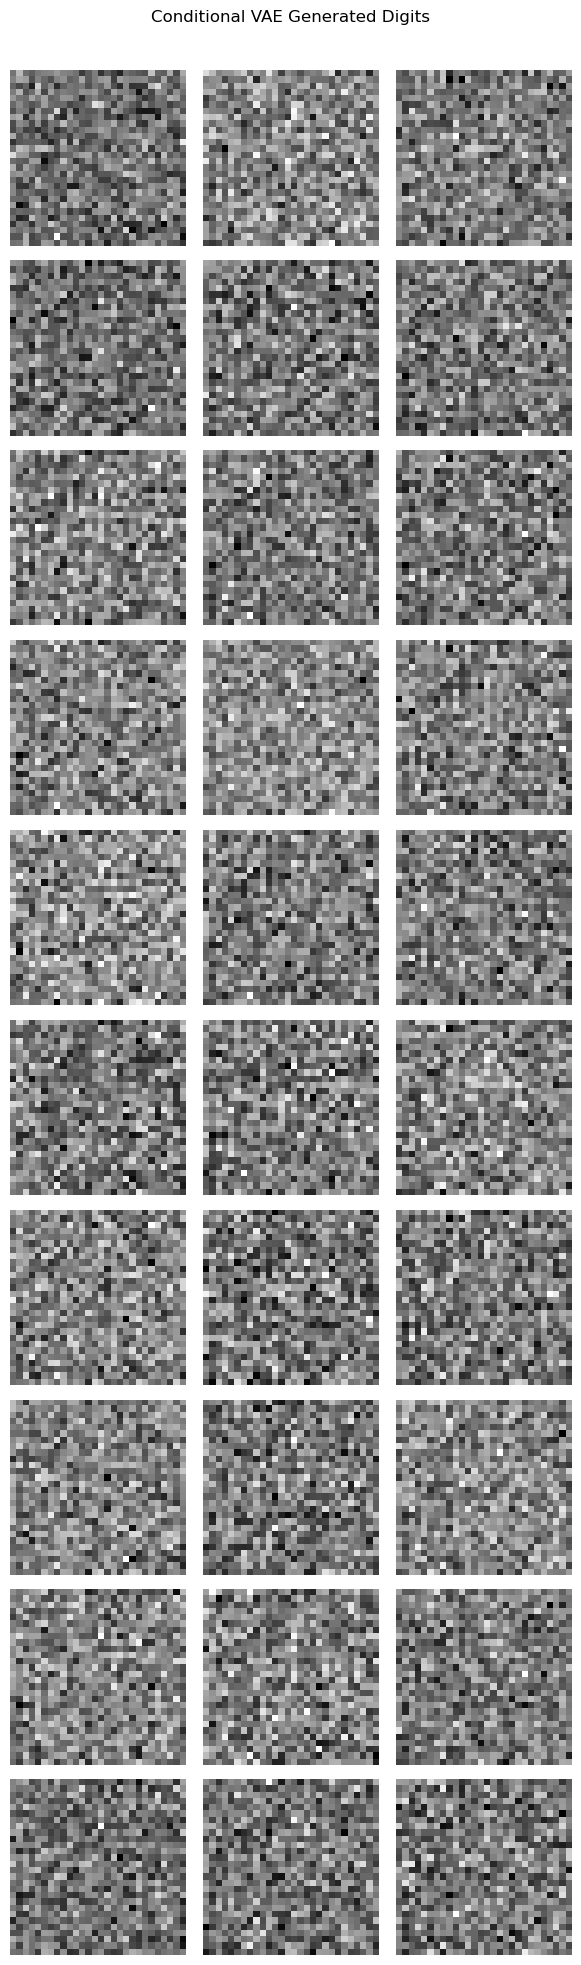


Testing generate_digits function...


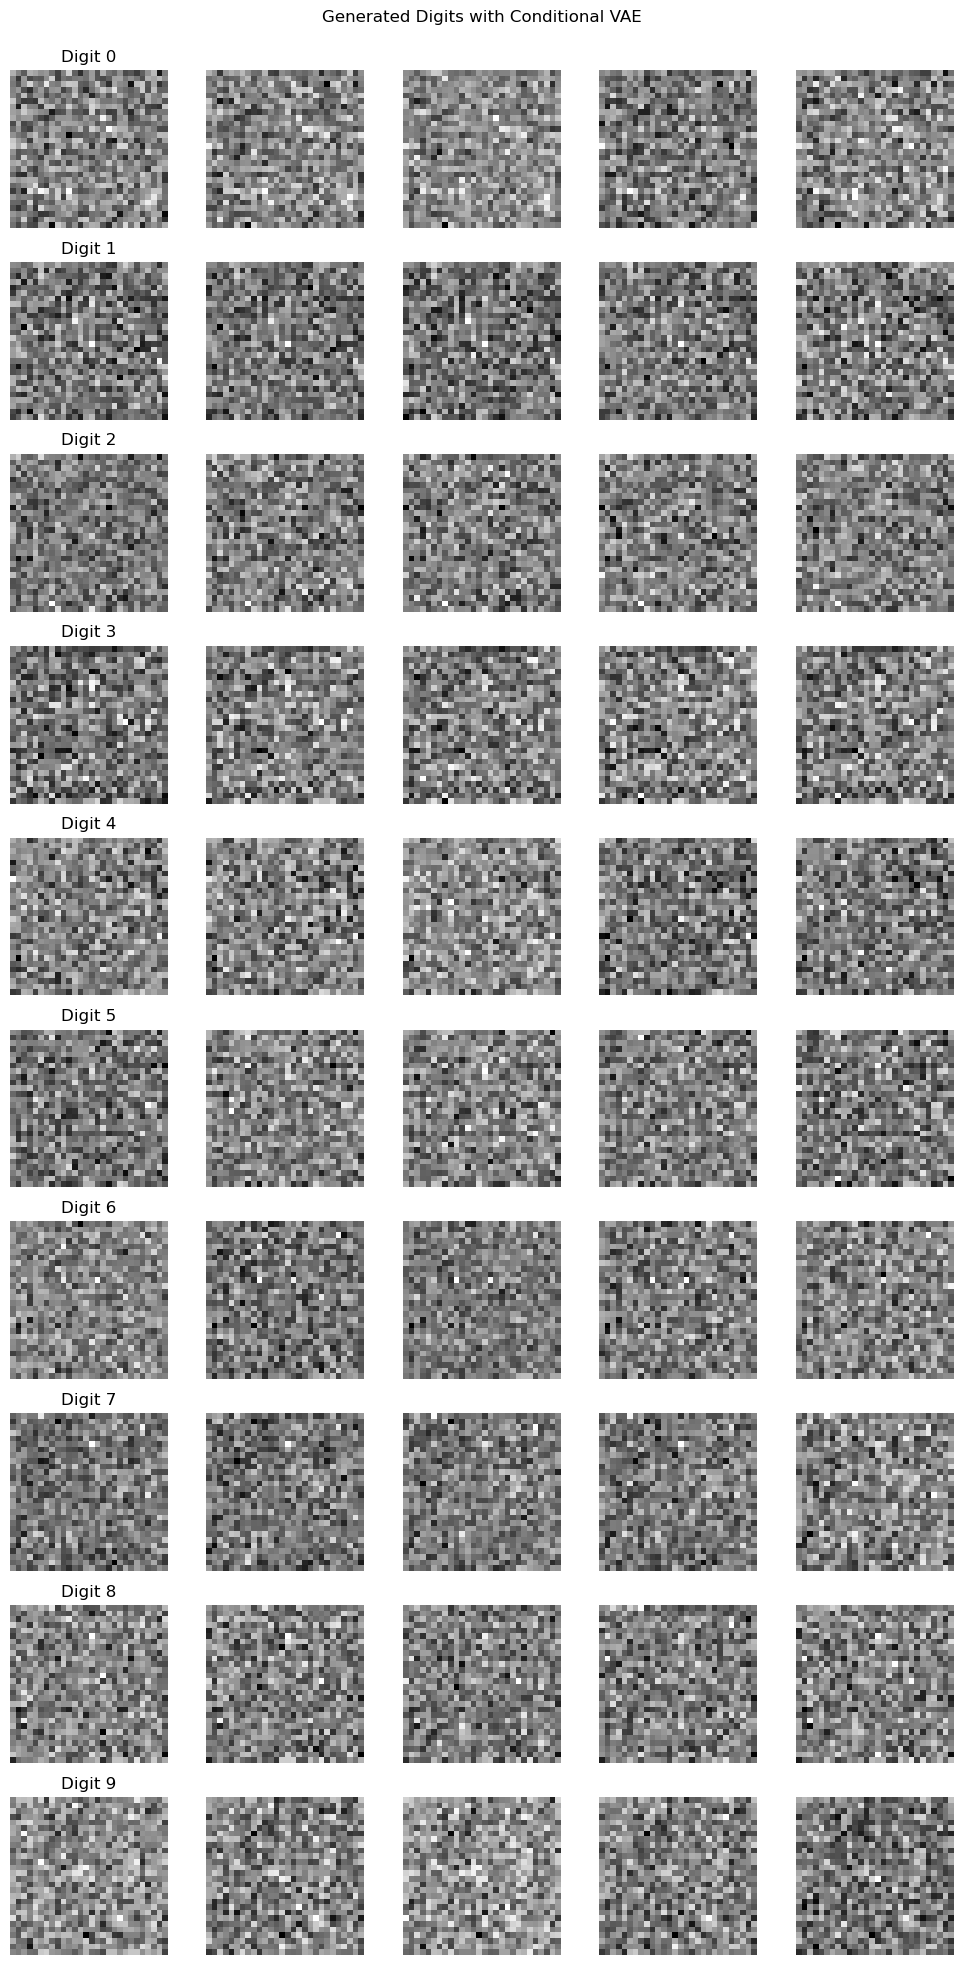

Conditional VAE test completed!

Testing with MNIST data including training

Enter number of epochs (recommended 10-30): 16
Enter learning rate (default: 0.001): 0.01
Enter beta value for KL divergence weight (default: 1.0): 1.0

Training CVAE for 16 epochs...


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 110.13it/s]


Epoch: 1, Average loss: 125.4354
Epoch 1, Loss: 125.4354


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 111.89it/s]


Epoch: 2, Average loss: 108.2701
Epoch 2, Loss: 108.2701


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 109.08it/s]


Epoch: 3, Average loss: 105.5850
Epoch 3, Loss: 105.5850


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 106.11it/s]


Epoch: 4, Average loss: 104.2000
Epoch 4, Loss: 104.2000


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 106.88it/s]


Epoch: 5, Average loss: 103.4506
Epoch 5, Loss: 103.4506
Model saved at epoch 5


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 104.97it/s]


Epoch: 6, Average loss: 102.8989
Epoch 6, Loss: 102.8989


100%|█████████████████████████████████████████| 469/469 [00:05<00:00, 88.91it/s]


Epoch: 7, Average loss: 102.4471
Epoch 7, Loss: 102.4471


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 105.36it/s]


Epoch: 8, Average loss: 102.0716
Epoch 8, Loss: 102.0716


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 113.58it/s]


Epoch: 9, Average loss: 101.7804
Epoch 9, Loss: 101.7804


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 113.08it/s]


Epoch: 10, Average loss: 101.5506
Epoch 10, Loss: 101.5506
Model saved at epoch 10


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 112.73it/s]


Epoch: 11, Average loss: 101.2371
Epoch 11, Loss: 101.2371


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 113.77it/s]


Epoch: 12, Average loss: 101.1256
Epoch 12, Loss: 101.1256


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 114.00it/s]


Epoch: 13, Average loss: 100.8850
Epoch 13, Loss: 100.8850


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 114.09it/s]


Epoch: 14, Average loss: 100.7942
Epoch 14, Loss: 100.7942


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 113.11it/s]


Epoch: 15, Average loss: 100.6029
Epoch 15, Loss: 100.6029
Model saved at epoch 15


100%|████████████████████████████████████████| 469/469 [00:04<00:00, 110.66it/s]


Epoch: 16, Average loss: 100.3808
Epoch 16, Loss: 100.3808
Model saved at epoch 16


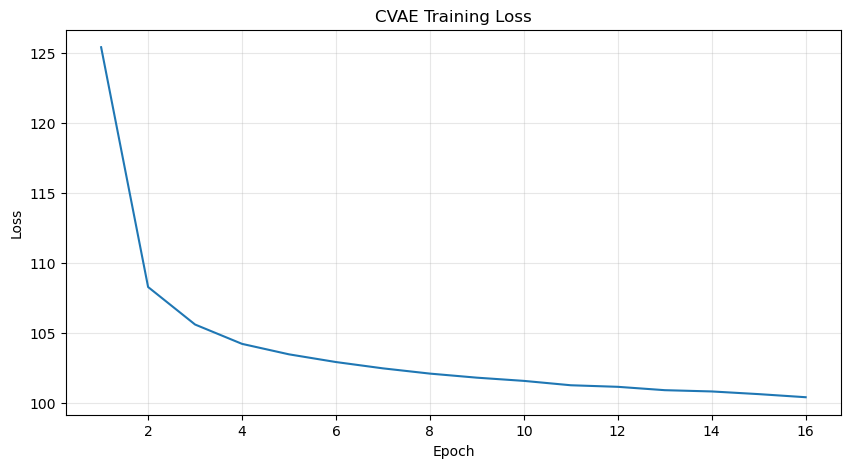


Generating digits with trained model...


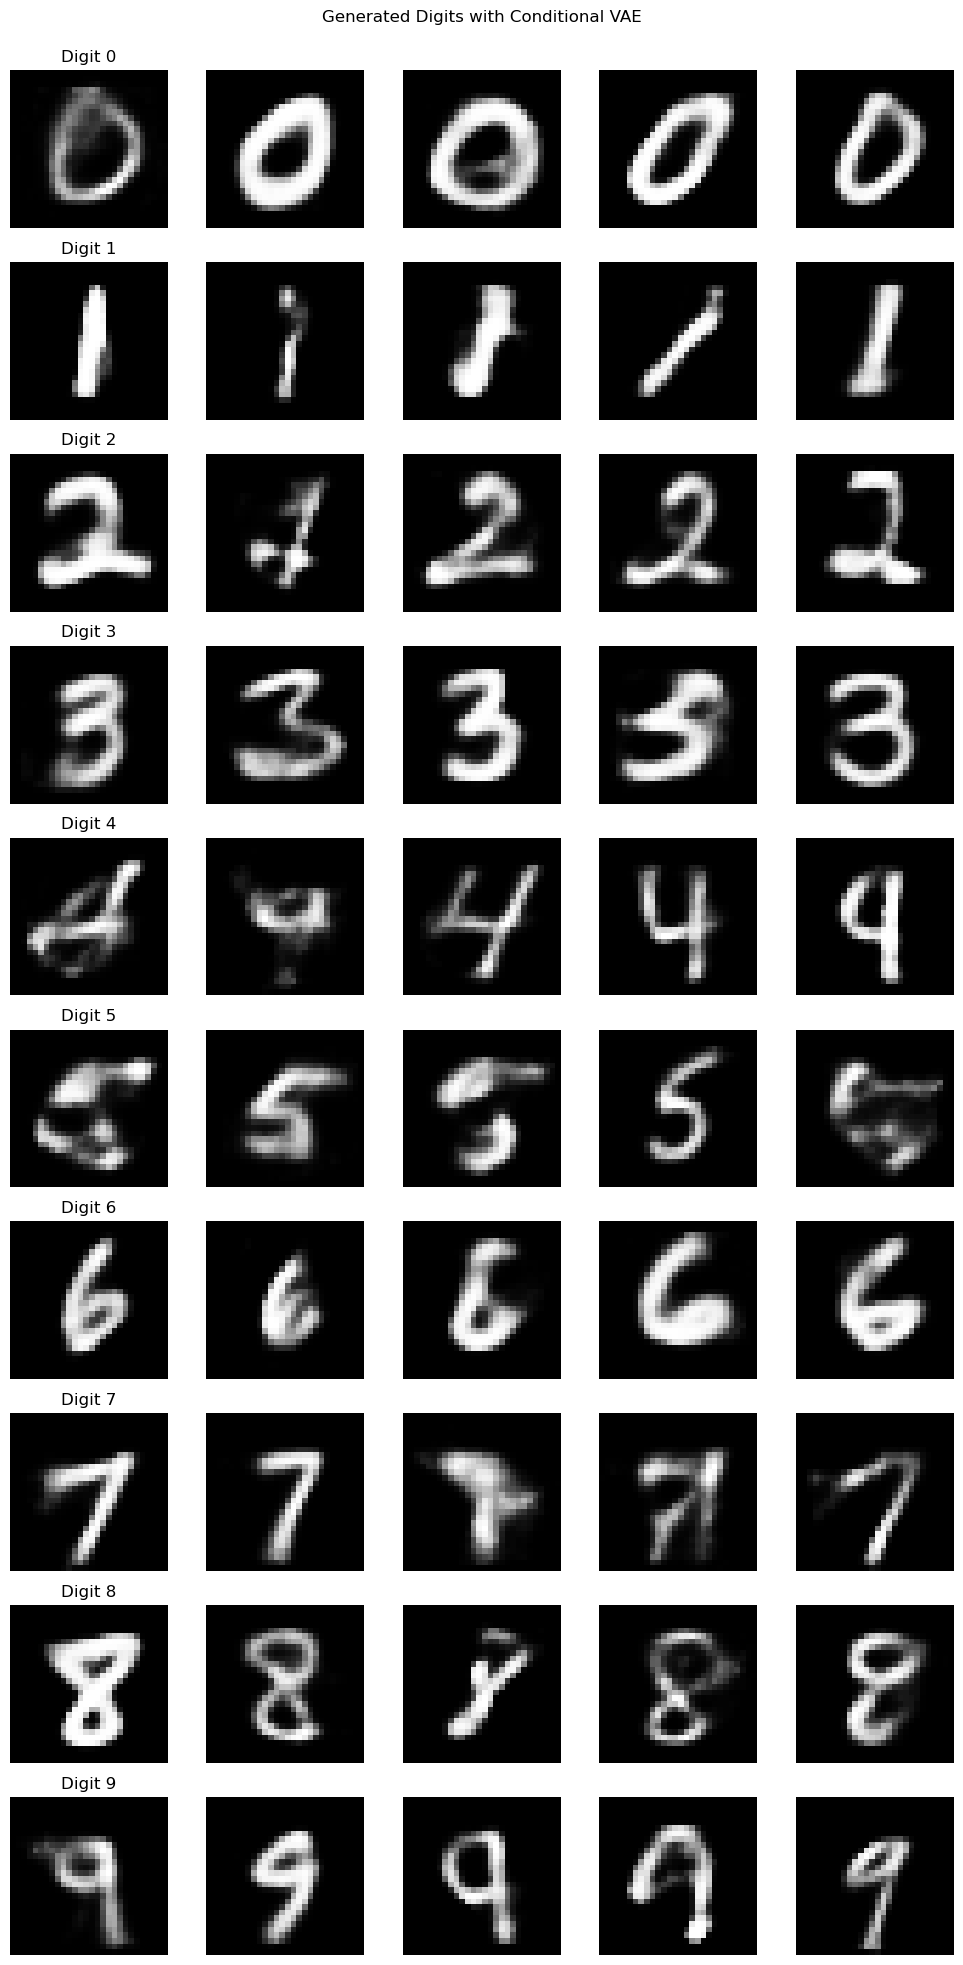

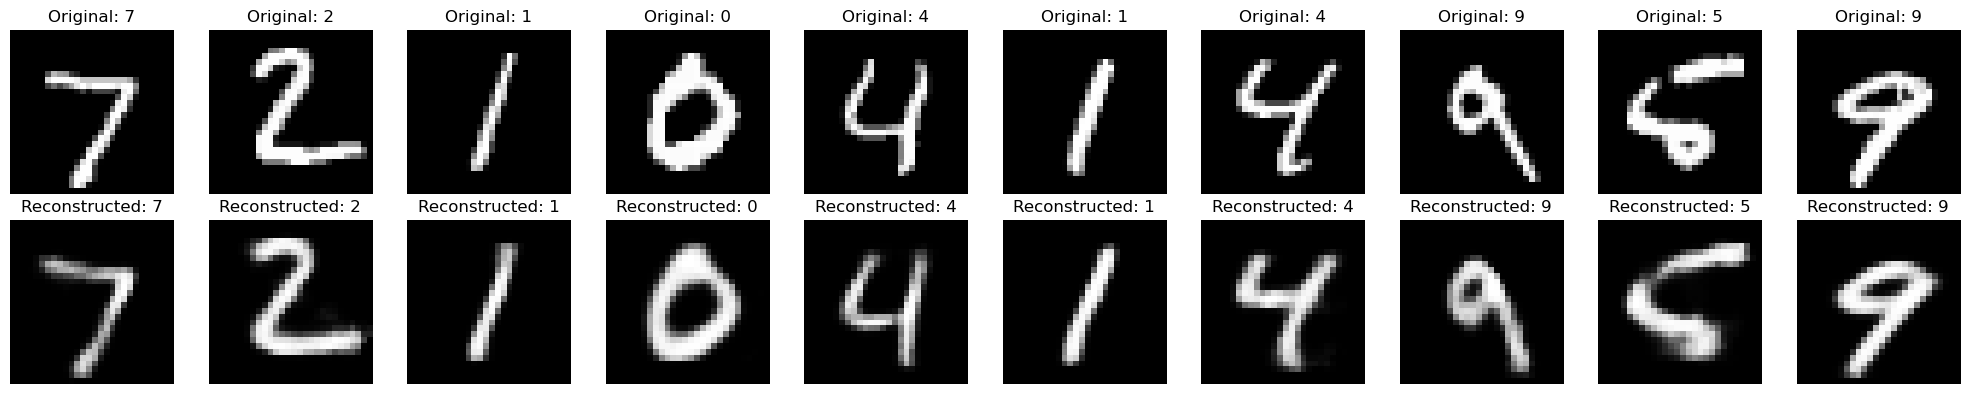

In [17]:
def test_conditional_vae():
    """
    Test the Conditional VAE implementation
    """
    # Define test parameters
    input_dim = 784
    hidden_dim = 400
    latent_dim = 20
    num_classes = 10
    
    print("Testing Conditional VAE...")
    
    # Create model instance
    cvae = ConditionalVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, num_classes=num_classes)
    print("Model created successfully")
    
    # 1. Test forward pass with random data
    print("\nTesting forward pass...")
    
    # Create random input
    batch_size = 5
    x = torch.rand(batch_size, 1, 28, 28)
    labels = torch.randint(0, num_classes, (batch_size,))
    
    # Forward pass
    recon_x, mu, logvar = cvae(x, labels)
    
    print(f"Input shape: {x.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Reconstructed shape: {recon_x.shape}")
    print(f"Mu shape: {mu.shape}")
    print(f"Logvar shape: {logvar.shape}")
    
    # 2. Test conditional generation
    print("\nTesting conditional generation...")
    
    # Generate examples for each digit
    samples_per_digit = 3
    generated_samples = []
    
    for digit in range(10):
        samples = cvae.generate(digit, num_samples=samples_per_digit)
        generated_samples.append(samples)
        print(f"Generated {samples_per_digit} samples for digit {digit}, shape: {samples.shape}")
    
    # 3. Visualize some generated examples
    print("\nVisualizing generated examples...")
    
    # Create a grid to show samples
    fig, axes = plt.subplots(10, samples_per_digit, figsize=(samples_per_digit * 2, 20))
    
    for i in range(10):
        for j in range(samples_per_digit):
            if samples_per_digit == 1:
                ax = axes[i]
            else:
                ax = axes[i, j]
                
            # Get the sample and reshape if needed
            sample = generated_samples[i][j]
            if len(sample.shape) == 1:  # If output is flat (784,)
                sample = sample.view(28, 28)
                
            # Display the image
            ax.imshow(sample.detach().cpu().numpy(), cmap='gray')
            if j == 0:
                ax.set_ylabel(f"Digit {i}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Conditional VAE Generated Digits")
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    # 4. Call generate_digits function
    print("\nTesting generate_digits function...")
    generate_digits(cvae, num_samples=5)
    
    print("Conditional VAE test completed!")
    
    return cvae, generated_samples

# Test with real MNIST data including training
def test_cvae_with_mnist_training(num_epochs=5, learning_rate=1e-3, beta=1.0):
    """Test Conditional VAE with actual MNIST data, including training"""
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    
    # Load train and test datasets
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    # Create data loaders
    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Create model
    cvae = ConditionalVAE(hidden_dim=512)  # Use larger hidden dimension
    
    # Create optimizer
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    
    # Train for specified epochs
    print(f"\nTraining CVAE for {num_epochs} epochs...")
    
    train_losses = []
    
    for epoch in range(1, num_epochs + 1):
        # Train the model using the train_cvae function
        train_loss = train_cvae(cvae, train_loader, optimizer, epoch, beta=beta)
        train_losses.append(train_loss)
        print(f"Epoch {epoch}, Loss: {train_loss:.4f}")
        
        # Save model checkpoint periodically
        if epoch % 5 == 0 or epoch == num_epochs:
            torch.save(cvae.state_dict(), f'cvae_epoch_{epoch}.pth')
            print(f"Model saved at epoch {epoch}")
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('CVAE Training Loss')
    plt.grid(alpha=0.3)
    plt.show()
    
    # Generate digits using the trained model
    print("\nGenerating digits with trained model...")
    generate_digits(cvae, num_samples=5)
    
    # Display reconstruction examples
    images, labels = next(iter(test_loader))
    with torch.no_grad():
        recon_images, _, _ = cvae(images, labels)
    
    # Visualize original and reconstructed images
    n = 10
    plt.figure(figsize=(20, 4))
    
    # Original images
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        plt.title(f"Original: {labels[i].item()}")
        plt.axis('off')
        
    # Reconstructed images  
    for i in range(n):
        plt.subplot(2, n, i+n+1)
        plt.imshow(recon_images[i].view(28, 28).numpy(), cmap='gray')
        plt.title(f"Reconstructed: {labels[i].item()}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    
    return cvae, train_losses

# Run tests
if __name__ == "__main__":
    # Ask if user wants to run just basic testing or full training
    print("CVAE Testing Options:")
    print("1: Run basic tests with random data")
    print("2: Train on MNIST (takes longer but produces better results)")
    print("3: Run both tests")
    
    choice = input("Enter your choice (1-3): ")
    
    if choice == "1" or choice == "3":
        # Test with random data
        cvae, samples = test_conditional_vae()
    
    if choice == "2" or choice == "3":
        # Test with MNIST data including training
        print("\n" + "="*50)
        print("Testing with MNIST data including training")
        print("="*50 + "\n")
        
        # Allow user to customize training parameters
        epochs = int(input("Enter number of epochs (recommended 10-30): ") or "15")
        lr = float(input("Enter learning rate (default: 0.001): ") or "0.001")
        beta = float(input("Enter beta value for KL divergence weight (default: 1.0): ") or "1.0")
        
        trained_cvae, losses = test_cvae_with_mnist_training(num_epochs=epochs, learning_rate=lr, beta=beta)